In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchtext
import json
import numpy as np
from tqdm import tqdm
from time import time

<h1>3-2. ELMo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-dataset:-IMBD" data-toc-modified-id="Prepare-dataset:-IMBD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare dataset: IMBD</a></span><ul class="toc-item"><li><span><a href="#For-pretraining" data-toc-modified-id="For-pretraining-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>For pretraining</a></span></li></ul></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span><ul class="toc-item"><li><span><a href="#Bidirectional-language-model" data-toc-modified-id="Bidirectional-language-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bidirectional language model</a></span></li><li><span><a href="#ELMo" data-toc-modified-id="ELMo-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ELMo</a></span></li></ul></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#Pretrain-bidirectional-language-model" data-toc-modified-id="Pretrain-bidirectional-language-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pretrain bidirectional language model</a></span><ul class="toc-item"><li><span><a href="#Intermediate-results" data-toc-modified-id="Intermediate-results-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Intermediate results</a></span></li></ul></li><li><span><a href="#Train-ELMo-for-sentiment-analysis" data-toc-modified-id="Train-ELMo-for-sentiment-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train ELMo for sentiment analysis</a></span></li></ul></li></ul></div>

## Prepare dataset: IMBD

In [2]:
from torchtext.experimental.datasets import IMDB
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("spacy")
train, test = IMDB(tokenizer=tokenizer, root="~/torchdata/")

/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.py:36: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.cu' mode='r' encoding='utf8'>
  SRC = (PWD / "_custom_kernels.cu").open("r", encoding="utf8").read()
/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.py:39: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_murmur3.cu' mode='r' encoding='utf8'>
  MMH_SRC = (PWD / "_murmur3.cu").open("r", encoding="utf8").read()
100%|██████████| 25000/25000 [00:26<00:00, 930.03lines/s] 


In [3]:
from collections import Counter

vocab = train.get_vocab()

v = Counter(['<s>', '</s>'])
v = torchtext.vocab.Vocab(v, specials=['<s>', '</s>'])
vocab.extend(v)

In [4]:
VOCAB_SIZE = len(vocab)
ngrams = 2

```python
ngrams = 2
bos = "<s>"
eos = "</s>"

x = []
y = []
for _, words in tqdm(train):
    # Begin-of-sentence token
    x.append([vocab.stoi[bos]] + words[0:ngrams-1].tolist())
    y.append(words[ngrams-1].item())
    
    # in-sentence tokens
    for i in range(len(words)-ngrams):
        text = words[i:i+ngrams]
        label = words[i+ngrams]
        x.append(text.tolist())
        y.append(label.tolist())
        
    # End-of-sentence token
    x.append(words[i+1:i+ngrams].tolist() + [vocab.stoi[eos]])
    y.append(vocab.stoi[eos])
```

```python
with open("./IMBD_bigram.json", "w") as w:
    json.dump({"data": x, "label": y}, w)
```

In [5]:
with open("./IMBD_bigram.json") as r:
    xy = json.load(r)

### For pretraining

* transform to character-level n-gram dataset
    * original script
```
%load https://gist.githubusercontent.com/akurniawan/30719686669dced49e7ced720329a616/raw/7b9f9967c01ce87ac505520a5aa58d3b24c55c66/translation_char_example.py
```
    * modified
```
%load https://gist.github.com/naturale0/6bb3b8a5c682bd281de87e408fa71bf1/raw/df8b7e198f149f81c4f72af977760b2eb3226cdf/translation_char_example.py
```

In [6]:
# Modified a little to fit classification
import itertools
from torchtext.experimental.datasets import TextClassificationDataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.experimental.functional import sequential_transforms

def build_char_vocab(data, index, 
                     bow="<w>", eow="</w>",
                     bos="<s>", eos="</s>"):
    """
    build character level vocabulary
    """
    tok_list = [
        [bow],
        [eow],
        [bos],
        [eos],
    ]
    for line in data:
        tokens = list(itertools.chain.from_iterable(line[index]))
        tok_list.append(tokens)
    return build_vocab_from_iterator(tok_list)


def stoi(vocab):
    """
    change string to index
    """
    def func(tok_iter):
        return [[vocab[char] for char in word]\
                for word in tok_iter]

    return func


def tokenize_char(bow="<w>", eow="</w>", 
                  bos="<s>", eos="</s>",
                  max_word_length=20):
    """
    attach bow, eow token and pad with token
    """
    def func(tok_iter):
        result = np.empty((len(tok_iter), max_word_length+2), dtype=object)
        result[:] = "<pad>"
        
        for i, word in enumerate(tok_iter):
            if "".join(word) == "<s>":
                # Begin-of-sentence token
                result[i, :3] = [bow, bos, eow] #+ ["<pad>"] * (max_word_length - 1)
            elif "".join(word) == "</s>":
                # End-of-sentence token
                result[i, :3] = [bow, eos, eow] #+ ["<pad>"] * (max_word_length - 1)
            else:
                # in-sentence words
                if len(word) < max_word_length:
                    result[i, :len(word)+2] = [bow] + word + [eow]
                else:
                    result[i, :] = [bow] + word[:max_word_length] + [eow]
                
                
#                 result[:len(tok_iter)] = [
#                     [bow] + word + [eow] \
#                     + ["<pad>"] * (max_word_length - len(word)) \
#                     if len(word) < max_word_length \
#                     else [bow] + word[:max_word_length] + [eow]
#                 for word in tok_iter]

        return result

    return func

In [7]:
x = xy["data"]
y = xy["label"]

In [8]:
# Cache training data for vocabulary construction
train_data = [([vocab.itos[ix] for ix in line[0]], line[1]) for line in tqdm(zip(x, y))]

6810715it [00:07, 873883.37it/s] 


In [9]:
train_data[:3]

[(['<s>', 'I'], 1657), (['I', 'rented'], 11), (['rented', 'I'], 14567)]

In [10]:
# Setup vocabularies (both words and chars)
char_vocab = build_char_vocab(train_data, index=0)

6810719lines [00:06, 987988.46lines/s] 


In [11]:
# Building the dataset with character level tokenization
def char_tokenizer(words):
    return [list(word) for word in words]

char_transform = sequential_transforms(
    char_tokenizer, 
    tokenize_char(), 
    stoi(char_vocab),
    lambda x: torch.tensor(x)
)

trainset = TextClassificationDataset(
    train_data,
    char_vocab,
    (char_transform, lambda x: x),
)

In [12]:
print([[char_vocab.itos[i] for i in w] for w in trainset[17][0]] [1][:13])

['<w>', 's', 'u', 'r', 'r', 'o', 'u', 'n', 'd', 'e', 'd', '</w>', '<pad>']


In [13]:
# Prepare DataLoader
# def collate_fn(batch):
#     text, label = zip(*batch)
#     label = torch.LongTensor(label)
#     text = torch.stack(text)
#     #lens = list(map(lambda x: len(x[(x != 0).all(dim=1)]), text))
    
#     return text, label

pretrainloader = data.DataLoader(trainset, 
                                 batch_size=256,
                                 num_workers=4)

In [14]:
xx, yy = next(iter(pretrainloader))

## Build the model

### Bidirectional language model

In [15]:
class CharConv(nn.Module):
    
    def __init__(self):
        super(CharConv, self).__init__()
        
        # Embedding layer
        CHAR_EMBEDDING_DIM = 16
        self.char_embedding = nn.Embedding(len(char_vocab), CHAR_EMBEDDING_DIM)
        
        # Conv layers
        self.conv1 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, 1)
        self.conv2 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, (1, 2))
        self.conv3 = nn.Conv2d(CHAR_EMBEDDING_DIM, 4, (1, 3))
        self.conv4 = nn.Conv2d(CHAR_EMBEDDING_DIM, 8, (1, 4))
        self.conv5 = nn.Conv2d(CHAR_EMBEDDING_DIM, 16, (1, 5))
        self.conv6 = nn.Conv2d(CHAR_EMBEDDING_DIM, 32, (1, 6))
        self.conv7 = nn.Conv2d(CHAR_EMBEDDING_DIM, 64, (1, 7))
        self.convs = [
            self.conv1, self.conv2, self.conv3,
            self.conv4, self.conv5, self.conv6, self.conv7,
        ]
        
    
    def forward(self, x):
        # character-level convolution
        x = self.char_embedding(x).permute(0,3,1,2)
        x = [conv(x) for conv in self.convs]
        x = [F.max_pool2d(x_c, kernel_size=(1, x_c.shape[3])) for x_c in x]
        x = [torch.squeeze(x_p) for x_p in x]
        x = torch.hstack(x)  # 1, n_batch, concat_length
        #x = x.view(2, 0, 1)
        
        return x

In [16]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        # Bi-LSTM
        self.lstm1 = nn.LSTM(128, 1024, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.proj = nn.Linear(2*1024, 2*128, bias=False)
        self.lstm2 = nn.LSTM(2*128, 1024, bidirectional=True)
    
    def forward(self, x):
        # reshape input
        x = x.view(-1, 128, ngrams).permute(2, 0, 1)
        
        # 1st LSTM layer
        o, (h1, __) = self.lstm1(x)
        o = self.dropout(o)
        
        # main connection
        p = self.proj(o)
        
        # skip connection
        x2 = x.repeat(1,1,2)
        x3 = x2 + p
        
        # 2nd LSTM layer
        _, (h2, __) = self.lstm2(x3)
        return h1, h2

In [17]:
class BiLangModel(nn.Module):
    """
    Bidirectional language model (will be pretrained)
    """
    def __init__(self, char_cnn, bi_lstm):
        super(BiLangModel, self).__init__()
        
        # Highway connection
        CHAR_EMBEDDING_DIM = 16
        self.highway = nn.Linear(ngrams * 128, ngrams * 128)
        self.transform = nn.Linear(ngrams * 128, ngrams * 128)
        self.char_cnn = char_cnn
        self.bi_lstm = bi_lstm
        
        # last layer: classifier
        self.fc = nn.Linear(ngrams * 1024, 1024)
        
    def forward(self, x):
        # Character-level convolution
        x = self.char_cnn(x)
        x = x.view(-1, ngrams*128)
        
        # highway
        h = self.highway(x)
        t_gate = torch.sigmoid(self.transform(x))
        c_gate = 1 - t_gate
        x = h * t_gate + x * c_gate
        
        # Bi-LSTM
        _, x = self.bi_lstm(x)
        
        # fully-connected layer (classify)
        x = x.view(-1, ngrams * 1024)
        x = self.fc(x)
        
        return x

In [18]:
charconv = CharConv()
bilstm = BiLSTM()
model = BiLangModel(charconv, bilstm)
model(xx).shape

torch.Size([256, 1024])

```python
from torchviz import make_dot

charconv = CharConv()
bilstm = BiLSTM()

model = BiLangModel(charconv, bilstm)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000])

make_dot(criterion(model(xx), yy).loss).render("BiLanguageModel", format="png")
```

![](BiLanguageModel.png)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-01


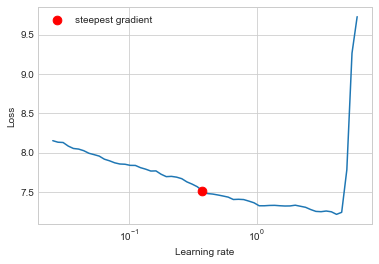

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.37649358067924676)

In [24]:
from torch_lr_finder import LRFinder

charconv = CharConv(); bilstm = BiLSTM()
model = BiLangModel(charconv, bilstm)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion_ = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
)
criterion = lambda x, y: criterion_(x, y).loss

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(pretrainloader, end_lr=100, num_iter=100)
lr_finder.plot(log_lr=True)

### ELMo

## Train the model

### Pretrain bidirectional language model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
).to(device)

In [28]:
charconv = CharConv()
bilstm = BiLSTM()

model = BiLangModel(charconv, bilstm).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
).to(device)

In [29]:
def accuracy(output, y):
    with torch.no_grad():
        pred = criterion.log_prob(output).argmax(dim=1)
    correct = (pred == y).float()
    #print(pred.shape, correct.shape)
    return correct.sum() / len(correct)

In [30]:
def train(model, dataloader, criterion, optimizer):
    loss_epoch = 0.
    acc_epoch = 0.
    for x, y in dataloader:
        model.zero_grad()
        
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        loss = criterion(out, y).loss
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(out, y).item()
    return loss_epoch, acc_epoch

In [31]:
losses = []
accs = []

In [32]:
N_EPOCH = 100
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1.,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(pretrainloader)
)

In [38]:
for i in range(1, N_EPOCH+1):
    t0 = time()
    
    loss_epoch, acc_epoch = train(model, pretrainloader, criterion, optimizer)
    losses.append(loss_epoch)
    accs.append(acc_epoch)
    scheduler.step()
    
    t1 = time()
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(pretrainloader): .3f}, acc: {acc_epoch/len(pretrainloader): .4f}, {t1-t0: .1f} sec")

epoch: 001, loss:  7.200, acc:  0.0421,  984.1 sec
epoch: 002, loss:  7.196, acc:  0.0425,  982.3 sec
epoch: 003, loss:  7.194, acc:  0.0427,  983.9 sec
epoch: 004, loss:  7.193, acc:  0.0428,  984.7 sec
epoch: 005, loss:  7.192, acc:  0.0429,  982.1 sec
epoch: 006, loss:  7.191, acc:  0.0431,  983.3 sec
epoch: 007, loss:  7.190, acc:  0.0432,  984.9 sec
epoch: 008, loss:  7.189, acc:  0.0433,  983.0 sec
epoch: 009, loss:  7.188, acc:  0.0434,  984.2 sec
epoch: 010, loss:  7.186, acc:  0.0437,  982.7 sec
epoch: 011, loss:  7.183, acc:  0.0440,  987.1 sec
epoch: 012, loss:  7.179, acc:  0.0446,  981.5 sec
epoch: 013, loss:  7.174, acc:  0.0454,  984.4 sec
epoch: 014, loss:  7.168, acc:  0.0462,  984.3 sec
epoch: 015, loss:  7.162, acc:  0.0469,  983.7 sec
epoch: 016, loss:  7.163, acc:  0.0466,  983.9 sec
epoch: 017, loss:  7.154, acc:  0.0478,  984.9 sec
epoch: 018, loss:  7.147, acc:  0.0487,  988.7 sec
epoch: 019, loss:  7.142, acc:  0.0493,  983.0 sec
epoch: 020, loss:  7.138, acc: 

In [39]:
torch.save({'model_state_dict': model.state_dict(),
            'loss': losses,
            'acc': accs},
           "./ELMo-BiLM_SGD_lr0.3-1._momentum0.9_epoch100.pth")

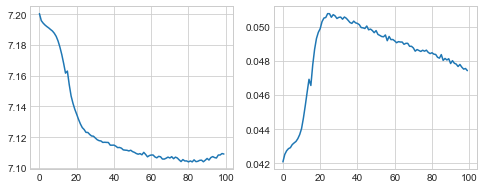

In [40]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.array(losses) / len(pretrainloader))
plt.subplot(122)
plt.plot(np.array(accs) / len(pretrainloader))

#### Intermediate results

In [20]:
charconv = CharConv()
bilstm = BiLSTM()
model = BiLangModel(charconv, bilstm)

checkpoint = torch.load("./ELMo-BiLM_SGD_lr0.3-1._momentum0.9_epoch100.pth")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [24]:
model.to(device)
model.eval()  # evaluation mode

BiLangModel(
  (highway): Linear(in_features=256, out_features=256, bias=True)
  (transform): Linear(in_features=256, out_features=256, bias=True)
  (char_cnn): CharConv(
    (char_embedding): Embedding(182, 16)
    (conv1): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(16, 2, kernel_size=(1, 2), stride=(1, 1))
    (conv3): Conv2d(16, 4, kernel_size=(1, 3), stride=(1, 1))
    (conv4): Conv2d(16, 8, kernel_size=(1, 4), stride=(1, 1))
    (conv5): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1))
    (conv6): Conv2d(16, 32, kernel_size=(1, 6), stride=(1, 1))
    (conv7): Conv2d(16, 64, kernel_size=(1, 7), stride=(1, 1))
  )
  (bi_lstm): BiLSTM(
    (lstm1): LSTM(128, 1024, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (proj): Linear(in_features=2048, out_features=256, bias=False)
    (lstm2): LSTM(256, 1024, bidirectional=True)
  )
  (fc): Linear(in_features=2048, out_features=1024, bias=True)
)

In [31]:
words_sample = list(zip(*vocab.freqs.most_common(150)))[0]
words_input = stoi(char_vocab)(tokenize_char()(char_tokenizer(words_sample)))
words_input = torch.tensor(words_input).view(1, 150, 22)
words_input = words_input.to(device)

In [51]:
def embedding(words_char):
    with torch.no_grad():
        char_cnn = model.char_cnn
        x1 = char_cnn.char_embedding(words_input).permute(0,3,1,2)
        x1 = [conv(x1) for conv in char_cnn.convs]
        x1 = [F.max_pool2d(x_c, kernel_size=(1, x_c.shape[3])) for x_c in x1]
        x1 = [torch.squeeze(x_p) for x_p in x1]
        x1 = torch.vstack(x1)  # 1, n_batch, concat_length
    return x1.detach().cpu().T

In [53]:
word_embedding = embedding(words_input)

In [57]:
from sklearn.manifold import TSNE

embed_xy = TSNE(2).fit_transform(word_embedding)

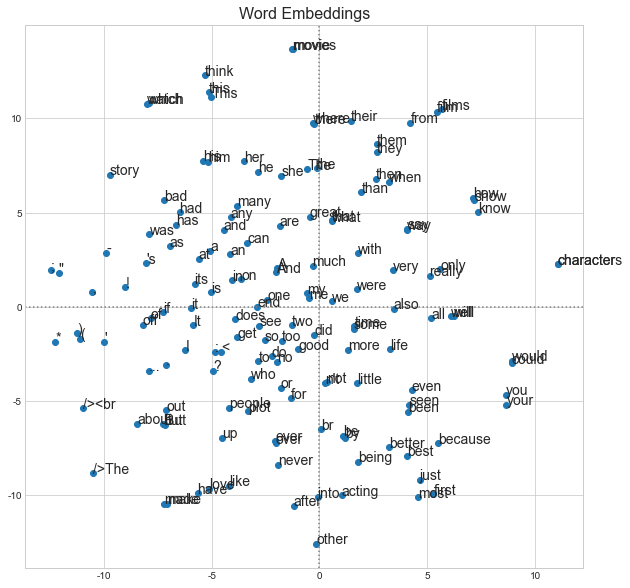

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(embed_xy[:, 0], embed_xy[:, 1])
plt.axhline(0, c="grey", ls=":")
plt.axvline(0, c="grey", ls=":")
for i, text in enumerate(words_sample):
    plt.annotate(text, (embed_xy[i, 0], embed_xy[i, 1]), fontsize=14)
plt.title("Word Embeddings", fontsize=16);

### Train ELMo for sentiment analysis